In [2]:
!python -m pip install --index-url https://support.bayesfusion.com/pysmile-A/ pysmile

Looking in indexes: https://support.bayesfusion.com/pysmile-A/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 3.1 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy
import itertools
import pysmile
import pprint

from collections import Counter


In [4]:
sns.set_style("whitegrid")

In [5]:
pysmile.License((
	b"SMILE LICENSE 2c4f954d 72216c8d e0e08fa1 "
	b"THIS IS AN ACADEMIC LICENSE AND CAN BE USED "
	b"SOLELY FOR ACADEMIC RESEARCH AND TEACHING, "
	b"AS DEFINED IN THE BAYESFUSION ACADEMIC "
	b"SOFTWARE LICENSING AGREEMENT. "
	b"Serial #: 6elhdnh8czmjbetdjhpo4d5vl "
	b"Issued for: Jaime Perez (jaime.perez.sanchez@gmail.com) "
	b"Academic institution: Universidad Pontificia Comillas "
	b"Valid until: 2023-11-17 "
	b"Issued by BayesFusion activation server"
	),[
	0x65,0x83,0x6e,0x39,0x81,0x24,0xbf,0x37,0x03,0x5e,0xb5,0x21,0xf1,0x77,0x2e,0x56,
	0xab,0x6b,0x43,0x35,0x23,0x31,0xa9,0xaf,0x98,0x23,0x48,0xae,0x87,0x60,0x02,0x1c,
	0xf5,0x6e,0x83,0x2d,0x47,0xda,0x5f,0x65,0x10,0xf3,0x4c,0x38,0x7c,0x71,0x19,0x20,
	0x00,0x27,0x04,0x9f,0x53,0x8a,0xe5,0x95,0x27,0xc1,0xa7,0xbd,0xa4,0x2b,0xd0,0xb2])

In [6]:
# from google_drive_downloader import GoogleDriveDownloader as gdd


# gdd.download_file_from_google_drive(file_id='1LkG3-BPtIVAgKzFw8Y3ZtqjABnWyGLMw',
#                                    dest_path='./DAG_OG_v2_trained.xdsl',
#                                    unzip=False)

# gdd.download_file_from_google_drive(file_id='1xMCNz9Ay7SID6fHuoOTOshdBGB6VUXAw',
#                                    dest_path='./DAG_FN_v2_trained.xdsl',
#                                    unzip=False)

# gdd.download_file_from_google_drive(file_id='1ofhqAkI6o0DBoVptThBdczvvAvsIuCW4',
#                                    dest_path='./DAG_CT_v2_trained.xdsl',
#                                    unzip=False)

In [7]:
# gdd.download_file_from_google_drive(file_id='1ejOgdFDoO-DJcBNvb0EznLIq3bDZAAoN',
#                                    dest_path='./data_DAG_OG_v2.csv',
#                                    unzip=False)

# gdd.download_file_from_google_drive(file_id='1hEHwxbIxOUBXsfwDBrUNgI7zCHlmxJDd',
#                                    dest_path='./data_DAG_FN_v2.csv',
#                                    unzip=False)

# gdd.download_file_from_google_drive(file_id='1p4Pd0M8sdQtcIC3dNrZ3nxdTXSezvK2z',
#                                    dest_path='./data_DAG_CT_v2.csv',
#                                    unzip=False)


In [8]:
normalization = math.sqrt(math.log(2))

In [9]:
network_file_OG = "DAG_OG_v2_trained.xdsl"
var_interest_OG = 'OG_risk'

network_file_FN = "DAG_FN_v2_trained.xdsl"
var_interest_FN = 'FN_risk'

network_file_CT = "DAG_CT_v2_trained.xdsl"
var_interest_CT = 'CT_risk'

In [10]:
def compute_rank_evidencesv2(num, values, DAG_file, var_interest):
  num_var = num
  dict_val = values
  net = pysmile.Network()
  net.read_file(DAG_file)
  net.update_beliefs()

  dict_results = {}
  dict_results_prob_ev = {}
  dict_results_norm = {}

  lst_groups = list(itertools.combinations(list(dict_val.keys()), num_var))

  for group in lst_groups:
    lst_values = [dict_val[val] for val in group]
    lst_iter = list(itertools.product(*lst_values))
    for subgroup in lst_iter:
      net.clear_all_evidence()
      # Set evidences
      for i in range(num_var):
        net.set_evidence(group[i], subgroup[i])
      # Update beleifs and get value
      net.update_beliefs()
      beliefs = net.get_node_value(var_interest)
      key_ = tuple(sorted([group[i]+str(subgroup[i]) for i in range(num_var)]))
      dict_results[key_] = beliefs[1]
      prob_e = net.prob_evidence()
      dict_results_prob_ev[key_] = prob_e
      dict_results_norm[key_] = beliefs[1]*prob_e/0.1

  df_ = pd.DataFrame.from_dict(dict_results, orient='index', columns=['P(Riksy|Evidence)'])
  df_prob_ev = pd.DataFrame.from_dict(dict_results_prob_ev, orient='index', columns=['P(Evidence)'])
  df_norm = pd.DataFrame.from_dict(dict_results_norm, orient='index', columns=['P(Evidence|Risky)'])
  df_extra_ = df_norm.join(df_prob_ev)
  df_extra = df_extra_.join(df_)
  return df_extra

In [74]:
def plot_var_count_elegant(df, var, threshold):
  all_indexes = []
  for i in df[df[var]>threshold].index:
    all_indexes.extend(i)

  len_df_filtered = len(df[df[var]>threshold])
  lst_percentage = [100*x/len_df_filtered for x in list(Counter(all_indexes).values())]
  df_count_ = pd.DataFrame(list(zip(lst_percentage, Counter(all_indexes).keys())), columns=['Percentage', 'Variable'])
  df_count = df_count_.sort_values(by=['Percentage'], ascending=False)

  dict_var_names = {'Previous_Victimization0': 'Previous Victimization = False',
                    'Honesty0': 'Honesty = Low',
                    'Honesty1': 'Honesty = Medium Low',
                    'Honesty2': 'Honesty = Medium',
                    'Honesty3': 'Honesty = High',
                    'Neuroticism_BF0': 'Neuroticism = Low',
                    'Neuroticism_BF1': 'Neuroticism = Medium',
                    'Neuroticism_BF2': 'Neuroticism = High',
                    'Conscientiousness_BF0': 'Conscientiousness = Low',
                    'Conscientiousness_BF1': 'Conscientiousness = Medium',
                    'Conscientiousness_BF2': 'Conscientiousness = High',
                    'Agreeableness_BF0': 'Agreeableness = Low',
                    'Agreeableness_BF1': 'Agreeableness = Medium',
                    'Agreeableness_BF2': 'Agreeableness = High',
                    'Introversion_BF0': 'Introversion = Low',
                    'Introversion_BF1': 'Introversion = Medium',
                    'Introversion_BF2': 'Introversion = High',
                    'Openness2Experience_BF0': 'Openness2Experience = Low',
                    'Openness2Experience_BF1': 'Openness2Experience = Medium',
                    'Openness2Experience_BF2': 'Openness2Experience = High',
                  'Previous_Victimization1': 'Previous Victimization = True',
                  'Gender0': 'Gender = Male',
                  'Gender1': 'Gender = Female',
                  'Gender2': 'Gender = Non Binary',
                  'Social_Support0': 'Social Support = Low',
                  'Social_Support1': 'Social Support = Medium',
                  'Social_Support2': 'Social Support = High',
                  'Family_Support0': 'Family Support = Low',
                  'Family_Support1': 'Family Support = Medium',
                  'Family_Support2': 'Family Support = High',
                  'Age0': 'Age = 12',
                  'Age1': 'Age = 13',
                  'Age2': 'Age = 14',
                  'Age3': 'Age = 15',
                  'Age4': 'Age = 16',
                  'Self_Esteem0': 'Self-Esteem = Low',
                  'Self_Esteem1': 'Self-Esteem = Medium',
                  'Self_Esteem2': 'Self-Esteem = High',
                  'Empathy0': 'Empathy = Low',
                  'Empathy1': 'Empathy = High',
                  'Migratory_background0': 'Migratory background = No',
                  'Migratory_background1': 'Migratory background = 2nd Gen.',
                  'Migratory_background2': 'Migratory background = 3rd Gen.',
                  'Sexual_Orientation0': 'Sexual Orientation = Heterosexual',
                  'Sexual_Orientation1': 'Sexual Orientation = Non Heterosexual',
                  'Hours_Internet0': 'Hours Internet = <1h',
                  'Hours_Internet1': 'Hours Internet = 1-2h',
                  'Hours_Internet2': 'Hours Internet = 2-3h',
                  'Hours_Internet3': 'Hours Internet = 3-4h',
                  'Hours_Internet4': 'Hours Internet = >4h'
                  }
  df_count_elegant = df_count.replace(dict_var_names)
  plt.figure(figsize=(10, 7))
  sns.barplot(data=df_count_elegant, x='Percentage', y='Variable', color='tab:blue')

  plt.xlim((0,100))
  # plt.savefig("5_Factors.pdf", format="pdf", bbox_inches="tight")
  # plt.xticks(rotation=90)
  plt.show()

In [11]:
def compute_rank_evidences(num, values):
  num_var = num
  dict_val = values
  net = pysmile.Network()
  net.read_file(network_file)
  net.update_beliefs()

  dict_results = {}
  dict_results_prob_ev = {}
  dict_results_norm = {}

  lst_groups = list(itertools.combinations(list(dict_val.keys()), num_var))

  for group in lst_groups:
    lst_values = [dict_val[val] for val in group]
    lst_iter = list(itertools.product(*lst_values))
    for subgroup in lst_iter:
      net.clear_all_evidence()
      # Set evidences
      for i in range(num_var):
        net.set_evidence(group[i], subgroup[i])
      # Update beleifs and get value
      net.update_beliefs()
      beliefs = net.get_node_value(var_interest)
      key_ = tuple(sorted([group[i]+str(subgroup[i]) for i in range(num_var)]))
      dict_results[key_] = beliefs[1]
      prob_e = net.prob_evidence()
      dict_results_prob_ev[key_] = prob_e
      dict_results_norm[key_] = beliefs[1]*prob_e/0.1

  df_ = pd.DataFrame.from_dict(dict_results, orient='index', columns=['P(Riksy|Evidence)'])
  df_prob_ev = pd.DataFrame.from_dict(dict_results_prob_ev, orient='index', columns=['P(Evidence)'])
  df_norm = pd.DataFrame.from_dict(dict_results_norm, orient='index', columns=['P(Evidence|Risky)'])
  df_extra_ = df_norm.join(df_prob_ev)
  df_extra = df_extra_.join(df_)
  return df_extra

In [12]:
def plot_var_count(df, var, threshold):
  all_indexes = []
  for i in df[df[var]>threshold].index:
    all_indexes.extend(i)

  len_df_filtered = len(df[df[var]>threshold])
  lst_percentage = [100*x/len_df_filtered for x in list(Counter(all_indexes).values())]
  df_count_ = pd.DataFrame(list(zip(lst_percentage, Counter(all_indexes).keys())), columns=['Percentage', 'Variable'])
  df_count = df_count_.sort_values(by=['Percentage'], ascending=False)

  plt.figure(figsize=(10, 6))
  sns.barplot(data=df_count, x='Percentage', y='Variable')
  plt.xlim((0,100))

  # plt.xticks(rotation=90)
  plt.show()

In [13]:
def plot_var_count_2(df, var, threshold):
  all_indexes = []
  for i in df[df[var]>0.25].index:
    all_indexes.extend(i)

  set_all_indexes = set(all_indexes)
  len_df_filtered = len(df[df['P(Riksy|Evidence)']>0.25])

  lst_percentage_2 = []
  for value in set_all_indexes:
    mask=[]
    for idx in df.index:
      mask.append(value in idx)
    df_tmp = df[mask]
    lst_percentage_2.append(df_tmp['P(Evidence)'].sum())

  df_count_ = pd.DataFrame(list(zip(lst_percentage_2, set_all_indexes)), columns=['Sum_Prob_evidences', 'Variable'])
  df_count = df_count_.sort_values(by=['Sum_Prob_evidences'], ascending=False)

  plt.figure(figsize=(10, 6))
  sns.barplot(data=df_count, x='Sum_Prob_evidences', y='Variable')

  # plt.xticks(rotation=90)
  plt.show()

## Game Questions


In [14]:
df_DAG_CT = pd.read_csv("data_DAG_CT_v2.csv")
df_DAG_FN = pd.read_csv("data_DAG_FN_v2.csv")
df_DAG_OG = pd.read_csv("data_DAG_OG_v2.csv")

In [15]:
dict_val_game = {'A1_1_PhotoSharing': [0,1],
                  'A1_2_Sociable': [0,1],
                  'A1_3_MatthewMeme': [0,1,2],
                  'A2_1_name': [0,1,2,3],
                  'A2_2_pass': [0,1,2],
                  'A2_3_prof_type': [0,1],
                  'A2_4_place': [0,1,2,3],
                  'A2_5_prof_photo': [0,1,2],
                  'A2_7_usepc': [0,1],
                  'A2_8_friend_rq': [0,1,2],
                  'A2_9_photos': [0,1],
                  'A2_10_photos_nk': [0,1],
                  'A2_11_photos_nkplus': [0,1],
                  'A2_12_ask_help': [0,1],
                  'A2_13_close_case': [0,1],
                  'A2_14_tell_parents': [0,1,2],
                  'A2_15_block_prof': [0,1],
                  'A3_1_pirated_Content': [0,1],
                  'A3_2_Pol_Pola': [0,1,2],
                  'A3_3_time_overrun': [0,1],
                  'A3_4_Pol_Bullied': [0,1,2],
                  'A3_5_remind_Matthew': [0,1,2],
                  'A3_6_Talk_Pol': [0,1],
                  'A3_7_Help_Pol': [0,1,2,3],
                  'A4_1_phishing': [0,1],
                  'A4_2_pass': [0,1,2],
                  'A4_3_stolen': [0,1],
                  'A4_4_other_stolen': [0,1],
                  'A5_1_secret': [0,1],
                  'A5_2_biology': [0,1],
                  'A5_3_sheila': [0,1],
                  'A6_1_news_check': [0,1,2,3],
                  'A6_2_look': [0,1],
                  'A6_3_source': [0,1],
                  'A6_4_accu': [0,1],
                  'A6_5_replay_post': [0,1],
                  'A6_6_regarding_charles': [0,1]}

In [16]:
dict_val_game_FN = {'A6_1_news_check': [0,1,2,3],
                  'A6_2_look': [0,1],
                  'A6_3_source': [0,1],
                  'A6_4_accu': [0,1],
                  'A6_5_replay_post': [0,1],
                  'A6_6_regarding_charles': [0,1]}

In [17]:
net = pysmile.Network()
net.read_file(network_file_FN)

In [18]:
net.get_all_node_ids()

['Age',
 'Gender',
 'Family_Support',
 'Social_Support',
 'Hours_Internet',
 'CB_Offending',
 'Migratory_background',
 'Conscientiousness_BF',
 'Agreeableness_BF',
 'Neuroticism_BF',
 'FN_risk',
 'Honesty',
 'A6_6_regarding_charles',
 'A6_4_accu',
 'A6_5_replay_post',
 'A6_3_source',
 'A6_2_look',
 'A6_1_news_check']

In [19]:
dict_val_game_OG = {'A2_1_name': [0,1,2],
                  'A2_3_prof_type': [0,1],
                  'A2_4_place': [0,1,2,3],
                  'A2_5_prof_photo': [0,1,2],
                  'A2_7_usepc': [0,1],
                  'A2_8_friend_rq': [0,1,2],
                  'A2_9_photos': [0,1],
                  'A2_10_photos_nk': [0,1],
                  'A2_11_photos_nkplus': [0,1],
                  'A2_12_ask_help': [0,1],
                  'A2_13_close_case': [0,1],
                  'A2_14_tell_parents': [0,1,2],
                  'A2_15_block_prof': [0,1],
                  'A5_1_secret': [0,1],
                  'A5_2_biology': [0,1],
                  'A5_3_sheila': [0,1],
  }

In [20]:
dict_val_game_FN = {'A6_1_news_check': [0,1,2,3],
                  'A6_2_look': [0,1],
                  'A6_3_source': [0,1],
                  'A6_4_accu': [0,1],
                  'A6_5_replay_post': [0,1],
                  'A6_6_regarding_charles': [0,1]}

### 1 variable analysis


In [21]:
df_q_1_join_ = compute_rank_evidencesv2(1, dict_val_game_FN, network_file_FN, var_interest_FN)
df_q_1_join = df_q_1_join_.sort_values(by=['P(Riksy|Evidence)'])
df_q_1_join

,P(Evidence|Risky),P(Evidence),P(Riksy|Evidence)
"(A6_3_source1,)",0.807103,0.605998,0.133186
"(A6_4_accu1,)",0.773892,0.568943,0.136023
"(A6_2_look1,)",1.037023,0.642303,0.161454
"(A6_6_regarding_charles1,)",1.266510,0.659848,0.191940
"(A6_1_news_check1,)",0.555873,0.288467,0.192699
"(A6_1_news_check3,)",0.595727,0.254115,0.234432
"(A6_5_replay_post1,)",1.415515,0.594142,0.238245
"(A6_1_news_check0,)",1.106739,0.300438,0.368376
"(A6_5_replay_post0,)",1.597957,0.405858,0.393723
"(A6_1_news_check2,)",0.755133,0.156981,0.481036


### 2 variable analysis


In [22]:
df_q_2_join_ = compute_rank_evidencesv2(2, dict_val_game_FN, network_file_FN, var_interest_FN)
df_q_2_join = df_q_2_join_.sort_values(by=['P(Riksy|Evidence)'])
df_q_2_join

,P(Evidence|Risky),P(Evidence),P(Riksy|Evidence)
"(A6_1_news_check1, A6_3_source1)",0.142849,0.196639,0.072645
"(A6_1_news_check1, A6_4_accu1)",0.138876,0.183176,0.075816
"(A6_3_source1, A6_4_accu1)",0.351999,0.463687,0.075913
"(A6_4_accu1, A6_6_regarding_charles1)",0.346762,0.452440,0.076643
"(A6_3_source1, A6_6_regarding_charles1)",0.371622,0.482719,0.076985
...,...,...,...
"(A6_3_source0, A6_4_accu0)",1.784477,0.288745,0.618010
"(A6_2_look0, A6_4_accu0)",1.621220,0.261647,0.619620
"(A6_2_look0, A6_3_source0)",1.639141,0.258815,0.633326
"(A6_1_news_check2, A6_3_source0)",0.617874,0.095779,0.645103


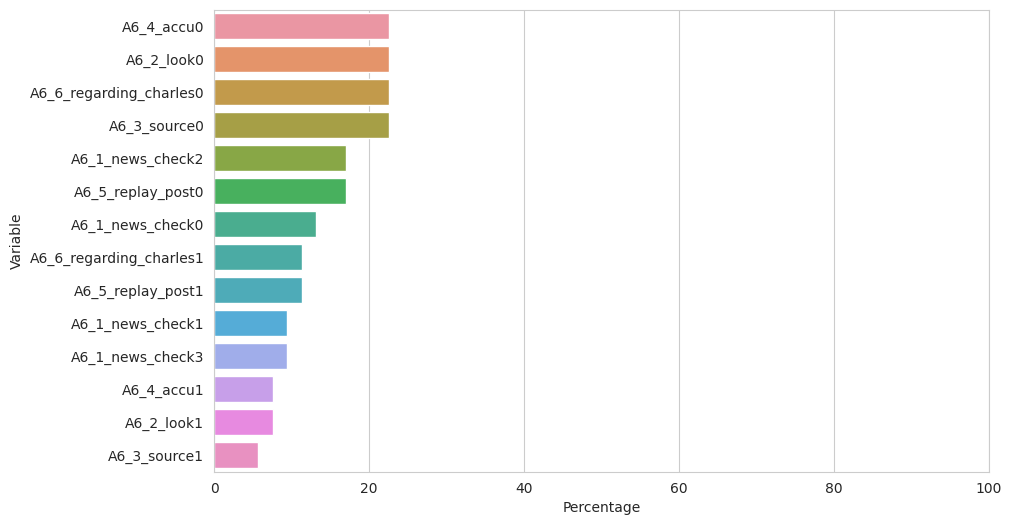

In [23]:
plot_var_count(df=df_q_2_join, var='P(Riksy|Evidence)', threshold=0.25)

### 3 variable analysis


In [24]:
df_q_3_join_ = compute_rank_evidencesv2(3, dict_val_game_FN, network_file_FN, var_interest_FN)
df_q_3_join = df_q_3_join_.sort_values(by=['P(Riksy|Evidence)'])
df_q_3_join

,P(Evidence|Risky),P(Evidence),P(Riksy|Evidence)
"(A6_1_news_check1, A6_3_source1, A6_4_accu1)",0.060388,0.155241,0.038900
"(A6_1_news_check1, A6_3_source1, A6_6_regarding_charles1)",0.065454,0.161816,0.040449
"(A6_1_news_check1, A6_4_accu1, A6_6_regarding_charles1)",0.061819,0.150575,0.041056
"(A6_3_source1, A6_4_accu1, A6_6_regarding_charles1)",0.172476,0.388544,0.044390
"(A6_1_news_check1, A6_2_look1, A6_4_accu1)",0.072707,0.156596,0.046429
...,...,...,...
"(A6_1_news_check3, A6_3_source0, A6_4_accu0)",0.252315,0.037380,0.675003
"(A6_1_news_check2, A6_2_look0, A6_3_source0)",0.489830,0.072129,0.679104
"(A6_2_look0, A6_3_source0, A6_5_replay_post1)",0.721981,0.104762,0.689164
"(A6_1_news_check2, A6_2_look0, A6_5_replay_post1)",0.264081,0.038233,0.690718


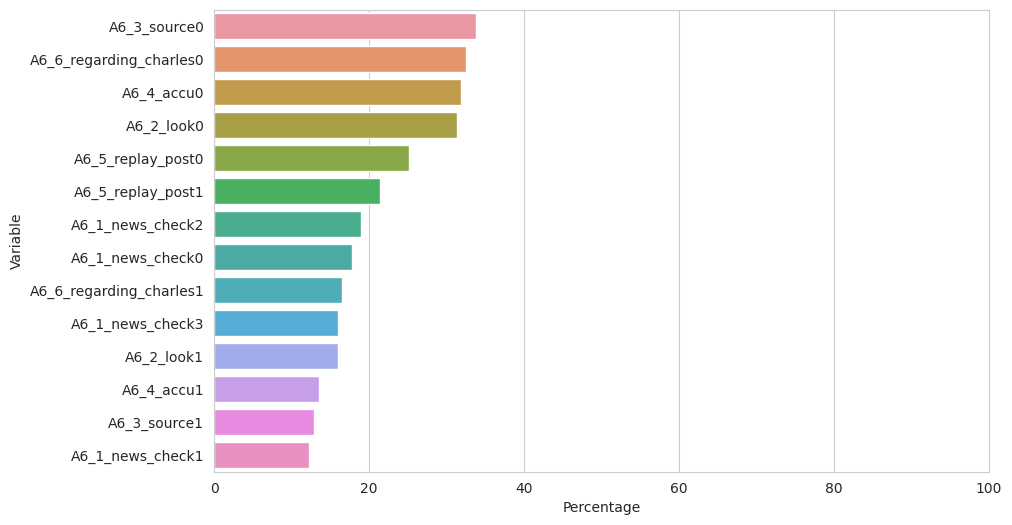

In [25]:
plot_var_count(df=df_q_3_join, var='P(Riksy|Evidence)', threshold=0.25)

### 4 variable analysis


In [26]:
df_q_4_join_ = compute_rank_evidencesv2(4, dict_val_game_FN, network_file_FN, var_interest_FN)
df_q_4_join = df_q_4_join_.sort_values(by=['P(Riksy|Evidence)'])
df_q_4_join

,P(Evidence|Risky),P(Evidence),P(Riksy|Evidence)
"(A6_1_news_check1, A6_3_source1, A6_4_accu1, A6_6_regarding_charles1)",0.029501,0.132149,0.022324
"(A6_1_news_check1, A6_2_look1, A6_4_accu1, A6_6_regarding_charles1)",0.035199,0.132637,0.026538
"(A6_1_news_check1, A6_2_look1, A6_3_source1, A6_6_regarding_charles1)",0.039337,0.142710,0.027564
"(A6_1_news_check1, A6_3_source1, A6_5_replay_post1, A6_6_regarding_charles1)",0.037217,0.116102,0.032055
"(A6_1_news_check1, A6_4_accu1, A6_5_replay_post1, A6_6_regarding_charles1)",0.035687,0.108270,0.032961
...,...,...,...
"(A6_1_news_check2, A6_3_source0, A6_4_accu0, A6_5_replay_post1)",0.226013,0.031351,0.720909
"(A6_1_news_check2, A6_2_look0, A6_3_source0, A6_4_accu1)",0.089213,0.012317,0.724295
"(A6_1_news_check2, A6_2_look0, A6_5_replay_post1, A6_6_regarding_charles0)",0.163436,0.022475,0.727200
"(A6_1_news_check2, A6_2_look0, A6_4_accu0, A6_5_replay_post1)",0.213533,0.029283,0.729198


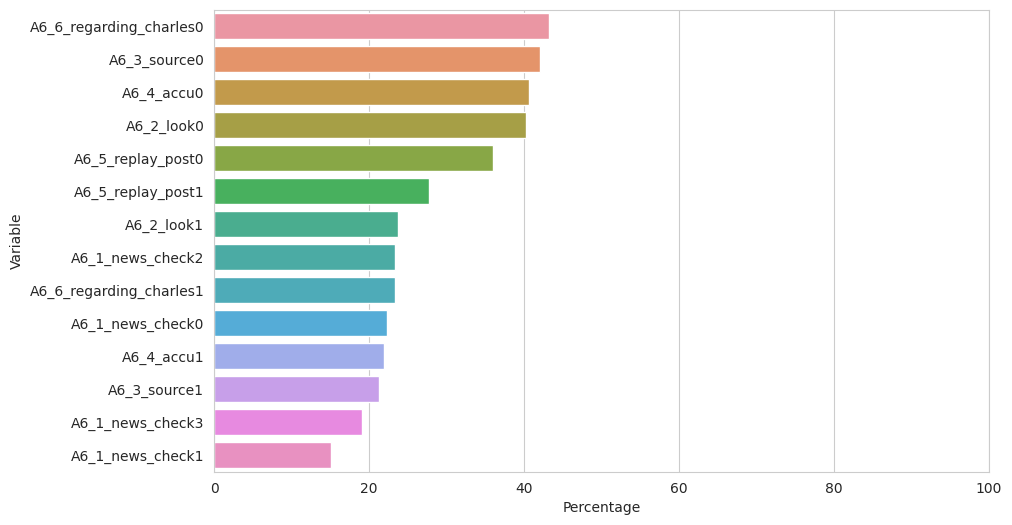

In [27]:
plot_var_count(df=df_q_4_join, var='P(Riksy|Evidence)', threshold=0.25)

### 5 variable analysis


In [28]:
df_q_5_join_ = compute_rank_evidencesv2(5, dict_val_game_FN, network_file_FN, var_interest_FN)
df_q_5_join = df_q_5_join_.sort_values(by=['P(Riksy|Evidence)'])
df_q_5_join

,P(Evidence|Risky),P(Evidence),P(Riksy|Evidence)
"(A6_1_news_check1, A6_2_look1, A6_3_source1, A6_4_accu1, A6_6_regarding_charles1)",0.023769,0.118747,0.020017
"(A6_1_news_check1, A6_3_source1, A6_4_accu1, A6_5_replay_post1, A6_6_regarding_charles1)",0.020159,0.096232,0.020949
"(A6_1_news_check1, A6_2_look1, A6_4_accu1, A6_5_replay_post1, A6_6_regarding_charles1)",0.023204,0.096436,0.024062
"(A6_1_news_check1, A6_2_look1, A6_3_source1, A6_5_replay_post1, A6_6_regarding_charles1)",0.025909,0.103566,0.025017
"(A6_1_news_check1, A6_3_source1, A6_4_accu1, A6_5_replay_post0, A6_6_regarding_charles1)",0.009342,0.035917,0.026010
...,...,...,...
"(A6_1_news_check2, A6_3_source0, A6_4_accu1, A6_5_replay_post1, A6_6_regarding_charles0)",0.033951,0.004573,0.742492
"(A6_1_news_check2, A6_2_look0, A6_3_source0, A6_5_replay_post1, A6_6_regarding_charles0)",0.143610,0.019247,0.746140
"(A6_1_news_check2, A6_2_look0, A6_3_source0, A6_4_accu0, A6_5_replay_post1)",0.186821,0.025021,0.746645
"(A6_1_news_check2, A6_2_look0, A6_3_source0, A6_5_replay_post1, A6_6_regarding_charles1)",0.086918,0.011364,0.764866


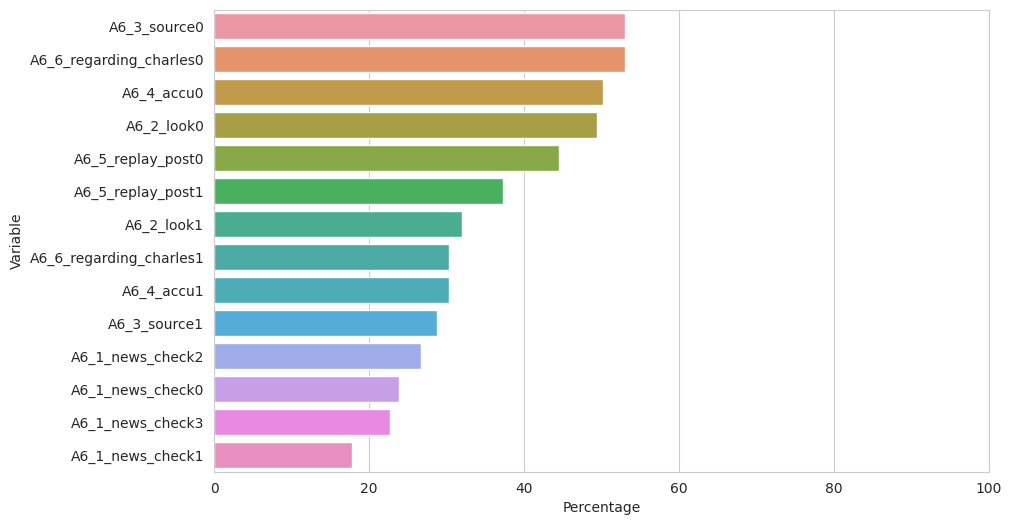

In [29]:
plot_var_count(df=df_q_5_join, var='P(Riksy|Evidence)', threshold=0.25)

### 6 variable analysis


In [30]:
df_q_6_join_ = compute_rank_evidencesv2(6, dict_val_game_FN, network_file_FN, var_interest_FN)
df_q_6_join = df_q_6_join_.sort_values(by=['P(Riksy|Evidence)'])
df_q_6_join

,P(Evidence|Risky),P(Evidence),P(Riksy|Evidence)
"(A6_1_news_check1, A6_2_look1, A6_3_source1, A6_4_accu1, A6_5_replay_post1, A6_6_regarding_charles1)",0.017083,0.086672,0.019709
"(A6_1_news_check1, A6_2_look1, A6_3_source1, A6_4_accu1, A6_5_replay_post0, A6_6_regarding_charles1)",0.006687,0.032075,0.020848
"(A6_1_news_check1, A6_2_look0, A6_3_source1, A6_4_accu1, A6_5_replay_post1, A6_6_regarding_charles1)",0.003077,0.009560,0.032185
"(A6_1_news_check0, A6_2_look1, A6_3_source1, A6_4_accu1, A6_5_replay_post1, A6_6_regarding_charles1)",0.024401,0.062572,0.038997
"(A6_1_news_check0, A6_2_look1, A6_3_source1, A6_4_accu1, A6_5_replay_post0, A6_6_regarding_charles1)",0.009902,0.022894,0.043252
...,...,...,...
"(A6_1_news_check2, A6_2_look0, A6_3_source0, A6_4_accu0, A6_5_replay_post1, A6_6_regarding_charles0)",0.116140,0.015815,0.734370
"(A6_1_news_check0, A6_2_look0, A6_3_source0, A6_4_accu0, A6_5_replay_post1, A6_6_regarding_charles1)",0.091322,0.012418,0.735396
"(A6_1_news_check2, A6_2_look0, A6_3_source0, A6_4_accu1, A6_5_replay_post1, A6_6_regarding_charles1)",0.016237,0.002157,0.752635
"(A6_1_news_check2, A6_2_look0, A6_3_source0, A6_4_accu0, A6_5_replay_post1, A6_6_regarding_charles1)",0.070681,0.009206,0.767731


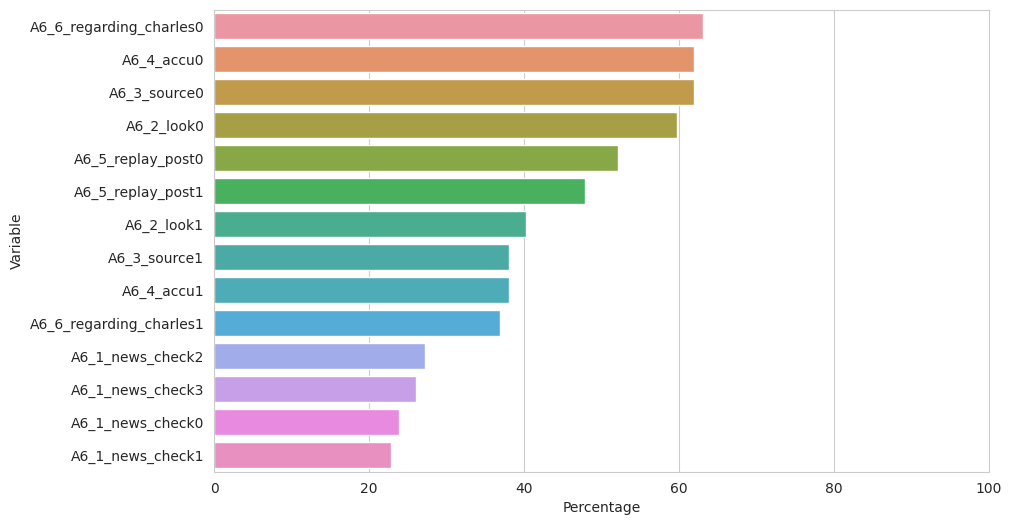

In [31]:
plot_var_count(df=df_q_6_join, var='P(Riksy|Evidence)', threshold=0.25)

## Demographics


In [32]:
dict_val = {'Age': [0,1,2,3,4],
           'Gender': [0,1,2],
           'Sexual_Orientation': [0,1],
           'Migratory_background': [0,1],
           'Hours_Internet': [0,1,2,3,4],
           'Social_Support': [0,1,2],
           'Family_Support': [0,1,2],
           'Self_Esteem': [0,1,2],
           'Empathy': [0,1],
           'Previous_Victimization': [0,1]
           }

dict_val_CT  = {'Age': [0,1,2,3,4],
           'Gender': [0,1,2],
           'Hours_Internet': [0,1,2,3,4],
           'Social_Support': [0,1,2],
           'Family_Support': [0,1,2],
           'Conscientiousness_BF': [0,1,2],
           'Agreeableness_BF': [0,1,2],
           'Neuroticism_BF': [0,1,2],
           'Honesty': [0,1,2,3]
          }

dict_val_FN = {'Age': [0,1,2,3,4],
           'Gender': [0,1,2],
           'Hours_Internet': [0,1,2,3,4],
           'Social_Support': [0,1,2],
           'Family_Support': [0,1,2],
           'Conscientiousness_BF': [0,1,2],
           'Agreeableness_BF': [0,1,2],
           'Neuroticism_BF': [0,1,2],
           'Honesty': [0,1,2,3]
          }

dict_val_FN = {'Age': [0,1,2,3,4],
           'Gender': [0,1,2],
           'Migratory_background': [0,1],
           'Hours_Internet': [0,1,2,3,4],
           'Social_Support': [0,1,2],
           'Family_Support': [0,1,2],
           'CB_Offending': [0,1],
           'Conscientiousness_BF': [0,1,2],
           'Agreeableness_BF': [0,1,2],
           'Neuroticism_BF': [0,1,2],
           'Honesty': [0,1,2,3]
          }

### 1 variable analysis

In [33]:
['Age',
 'Gender',
 'Family_Support',
 'Social_Support',
 'Hours_Internet',
 'CB_Offending',
 'Migratory_background',
 'Conscientiousness_BF',
 'Agreeableness_BF',
 'Neuroticism_BF',
 'FN_risk',
 'Honesty',
 'A6_6_regarding_charles',
 'A6_4_accu',
 'A6_5_replay_post',
 'A6_3_source',
 'A6_2_look',
 'A6_1_news_check']

['Age',
 'Gender',
 'Family_Support',
 'Social_Support',
 'Hours_Internet',
 'CB_Offending',
 'Migratory_background',
 'Conscientiousness_BF',
 'Agreeableness_BF',
 'Neuroticism_BF',
 'FN_risk',
 'Honesty',
 'A6_6_regarding_charles',
 'A6_4_accu',
 'A6_5_replay_post',
 'A6_3_source',
 'A6_2_look',
 'A6_1_news_check']

In [34]:
df_1_join_ = compute_rank_evidencesv2(1, dict_val_FN,
                                      network_file_FN, var_interest_FN)
df_1_join = df_1_join_.sort_values(by=['P(Riksy|Evidence)'])
df_1_join

,P(Evidence|Risky),P(Evidence),P(Riksy|Evidence)
"(Honesty2,)",0.639001,0.318405,0.200688
"(Honesty0,)",0.497117,0.188269,0.264046
"(Neuroticism_BF0,)",1.147527,0.384158,0.298713
"(Conscientiousness_BF0,)",0.926625,0.309982,0.298929
"(Age0,)",0.598322,0.200000,0.299161
"(Family_Support0,)",0.277949,0.092734,0.299726
"(Gender1,)",1.438896,0.480000,0.299770
"(Hours_Internet1,)",0.752154,0.250807,0.299894
"(Conscientiousness_BF2,)",0.760807,0.253663,0.299928
"(Gender2,)",0.119974,0.040000,0.299935


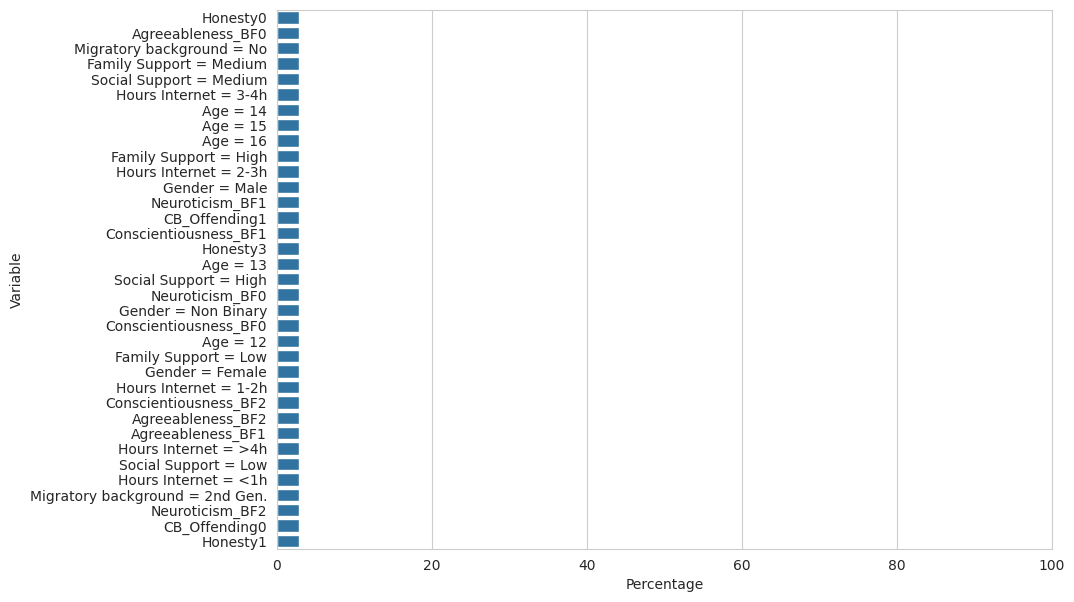

In [37]:
plot_var_count_elegant(df=df_1_join, var='P(Riksy|Evidence)', threshold=0.25)

### 2 variables analysis

In [38]:
df_2_join_ = compute_rank_evidencesv2(2, dict_val_FN,
                                      network_file_FN, var_interest_FN)
df_2_join = df_2_join_.sort_values(by=['P(Riksy|Evidence)'])
df_2_join

,P(Evidence|Risky),P(Evidence),P(Riksy|Evidence)
"(Honesty2, Neuroticism_BF0)",0.243331,0.122472,0.198684
"(Conscientiousness_BF0, Honesty2)",0.196489,0.098814,0.198848
"(Age0, Honesty2)",0.126873,0.063747,0.199024
"(Family_Support0, Honesty2)",0.058938,0.029550,0.199454
"(Gender1, Honesty2)",0.305115,0.152949,0.199488
...,...,...,...
"(Honesty1, Hours_Internet2)",0.427226,0.102162,0.418183
"(Gender0, Honesty1)",0.618036,0.147497,0.419014
"(Honesty1, Neuroticism_BF1)",0.628361,0.149747,0.419617
"(CB_Offending1, Honesty1)",0.245310,0.058457,0.419639


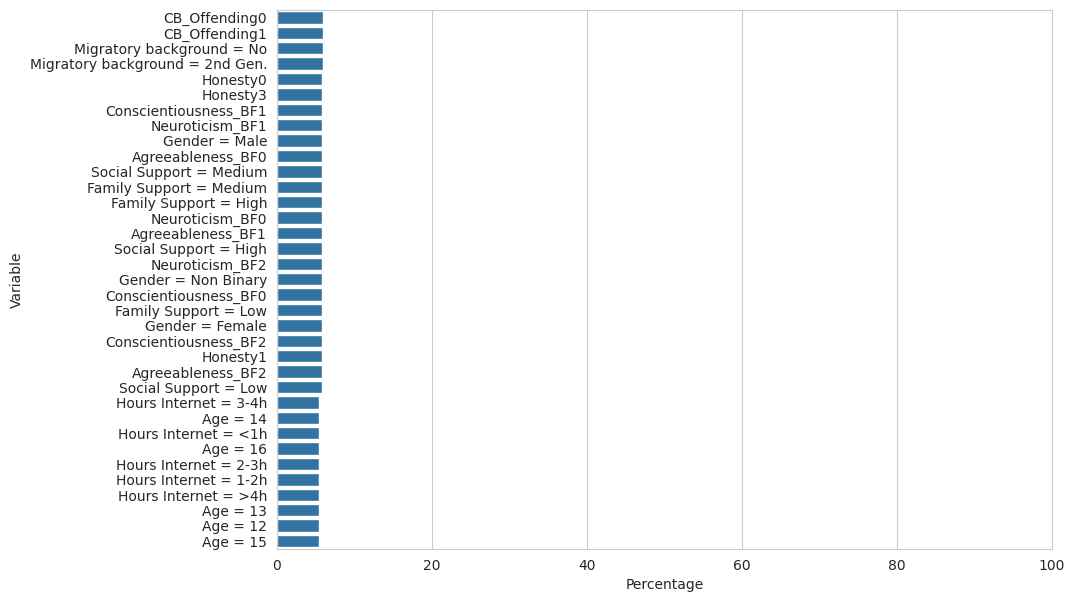

In [39]:
plot_var_count_elegant(df=df_2_join, var='P(Riksy|Evidence)', threshold=0.25)

### 3 variables analysis

In [40]:
df_3_join_ = compute_rank_evidencesv2(3, dict_val_FN,
                                      network_file_FN, var_interest_FN)
df_3_join = df_3_join_.sort_values(by=['P(Riksy|Evidence)'])
df_3_join

,P(Evidence|Risky),P(Evidence),P(Riksy|Evidence)
"(Age0, Agreeableness_BF1, Honesty2)",0.052168,0.026745,0.195058
"(Age0, Honesty2, Neuroticism_BF0)",0.047924,0.024548,0.195227
"(Age0, Honesty2, Hours_Internet1)",0.041073,0.020966,0.195906
"(Age1, Conscientiousness_BF0, Honesty2)",0.038929,0.019789,0.196716
"(Age0, Conscientiousness_BF0, Honesty2)",0.038930,0.019789,0.196727
...,...,...,...
"(Age3, Honesty1, Social_Support1)",0.094629,0.022383,0.422771
"(Conscientiousness_BF1, Gender0, Honesty1)",0.272789,0.064485,0.423030
"(Conscientiousness_BF1, Honesty1, Hours_Internet2)",0.189469,0.044700,0.423868
"(Gender0, Honesty1, Neuroticism_BF1)",0.305419,0.072029,0.424020


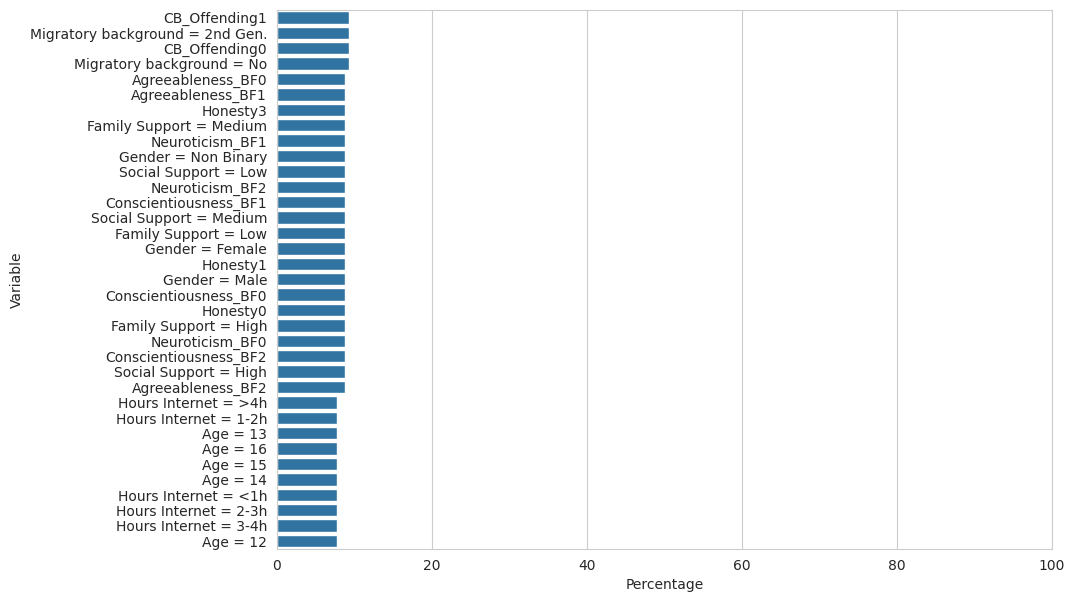

In [41]:
plot_var_count_elegant(df=df_3_join, var='P(Riksy|Evidence)', threshold=0.25)

### 4 variables analysis

In [42]:
df_4_join_ = compute_rank_evidencesv2(4, dict_val_FN,
                                      network_file_FN, var_interest_FN)
df_4_join = df_4_join_.sort_values(by=['P(Riksy|Evidence)'])
df_4_join

,P(Evidence|Risky),P(Evidence),P(Riksy|Evidence)
"(Age0, Agreeableness_BF1, Honesty2, Hours_Internet1)",0.016714,0.008808,0.189755
"(Age0, Agreeableness_BF1, Honesty2, Neuroticism_BF0)",0.019577,0.010308,0.189928
"(Age0, Honesty2, Hours_Internet1, Neuroticism_BF0)",0.015368,0.008084,0.190119
"(Age0, Agreeableness_BF1, Honesty2, Social_Support2)",0.028804,0.015090,0.190883
"(Age0, Gender0, Honesty2, Hours_Internet1)",0.019587,0.010213,0.191780
...,...,...,...
"(Age1, Agreeableness_BF1, Conscientiousness_BF1, Honesty1)",0.048562,0.011284,0.430367
"(Age0, Agreeableness_BF0, Honesty1, Hours_Internet2)",0.038626,0.008973,0.430446
"(Age3, Gender0, Honesty1, Neuroticism_BF1)",0.062345,0.014456,0.431274
"(Conscientiousness_BF1, Gender0, Honesty1, Neuroticism_BF1)",0.136058,0.031541,0.431367


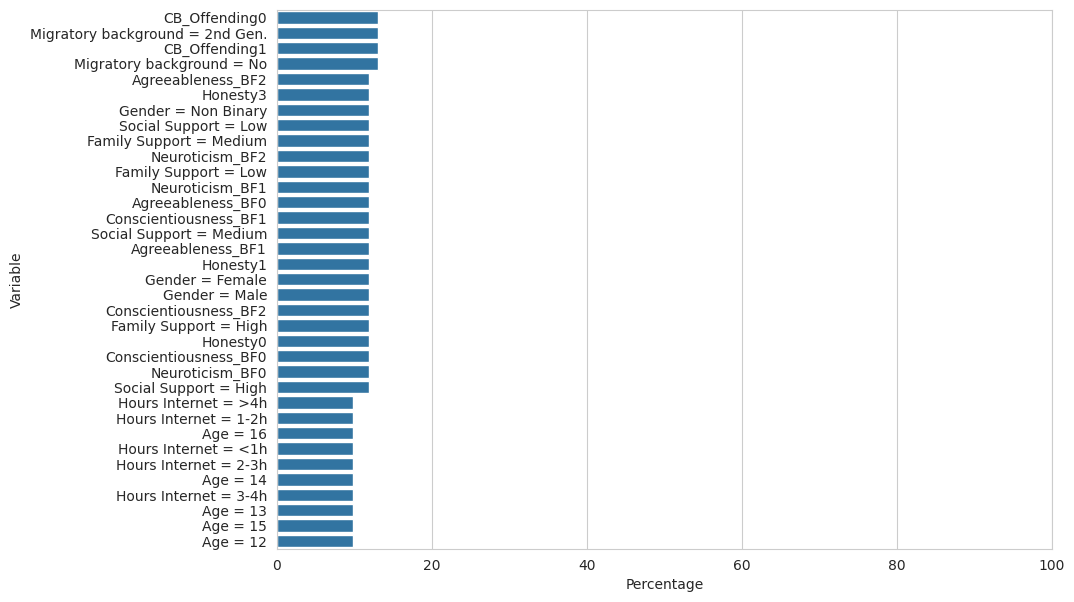

In [43]:
plot_var_count_elegant(df=df_4_join, var='P(Riksy|Evidence)', threshold=0.25)

### 5 variables analysis

In [44]:
df_5_join_ = compute_rank_evidencesv2(5, dict_val_FN,
                                      network_file_FN, var_interest_FN)
df_5_join = df_5_join_.sort_values(by=['P(Riksy|Evidence)'])
df_5_join

,P(Evidence|Risky),P(Evidence),P(Riksy|Evidence)
"(Age0, Agreeableness_BF1, Honesty2, Hours_Internet1, Neuroticism_BF0)",0.006143,0.003404,0.180479
"(Age0, Agreeableness_BF1, Gender0, Honesty2, Hours_Internet1)",0.007799,0.004303,0.181244
"(Age0, Honesty2, Hours_Internet1, Migratory_background0, Neuroticism_BF0)",0.009746,0.005316,0.183344
"(Age3, Gender0, Honesty2, Neuroticism_BF0, Social_Support2)",0.012268,0.006679,0.183682
"(Age0, Conscientiousness_BF0, Gender0, Honesty2, Hours_Internet1)",0.005849,0.003182,0.183824
...,...,...,...
"(Age3, Agreeableness_BF0, Conscientiousness_BF1, Honesty1, Neuroticism_BF1)",0.026153,0.005851,0.447003
"(Age0, Conscientiousness_BF1, Honesty1, Hours_Internet2, Neuroticism_BF1)",0.019483,0.004353,0.447577
"(Age4, CB_Offending1, Conscientiousness_BF0, Honesty1, Hours_Internet3)",0.008229,0.001834,0.448690
"(Age0, Agreeableness_BF0, Conscientiousness_BF1, Honesty1, Hours_Internet2)",0.017727,0.003950,0.448755


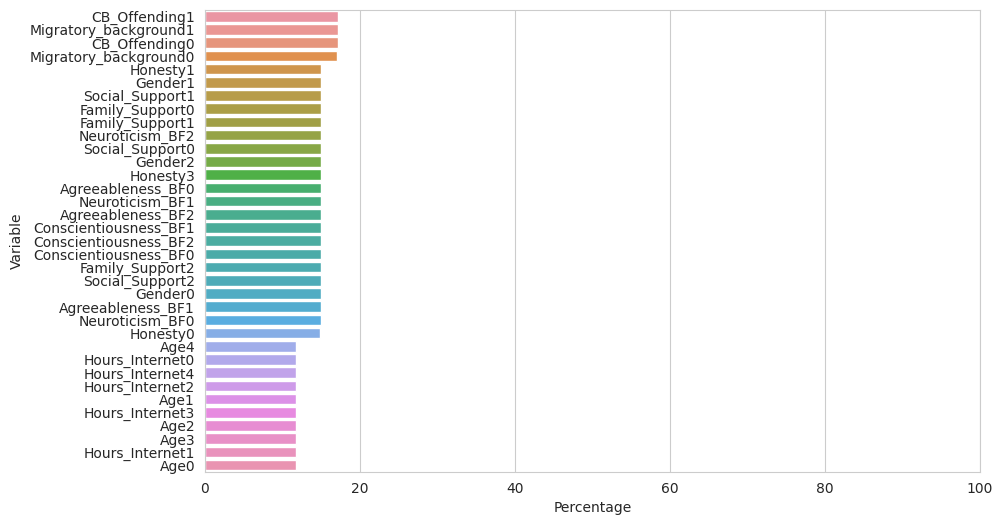

In [45]:
plot_var_count(df=df_5_join, var='P(Riksy|Evidence)', threshold=0.25)

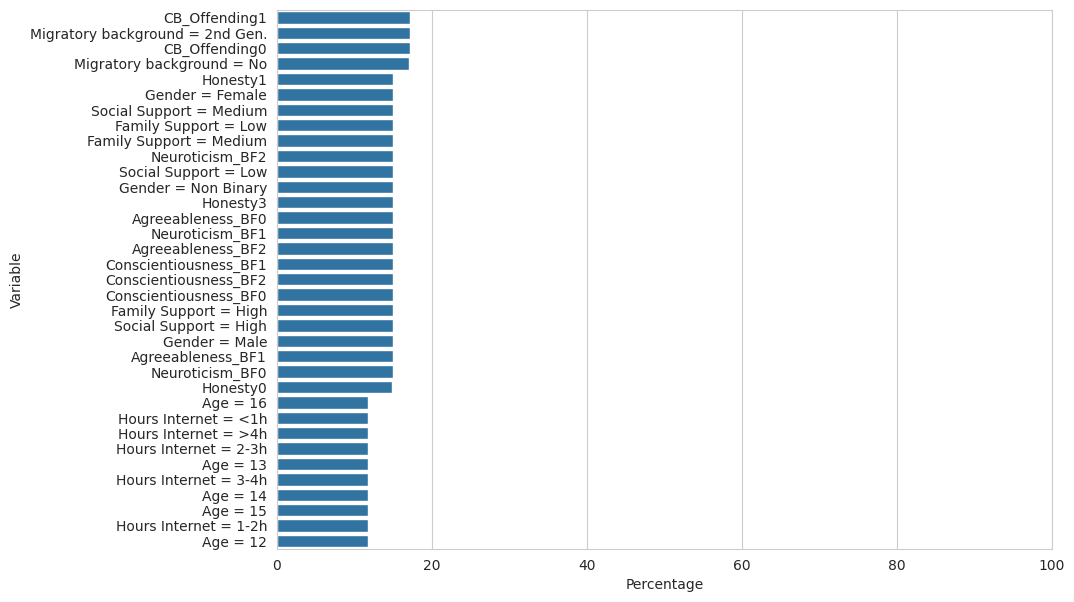

In [46]:
plot_var_count_elegant(df=df_5_join, var='P(Riksy|Evidence)', threshold=0.25)

In [ ]:
# all_indexes = []
# for i in df_5_join[df_5_join['P(Riksy|Evidence)']>0.25].index:
#   all_indexes.extend(i)

# len_df_filtered = len(df_5_join[df_5_join['P(Riksy|Evidence)']>0.25])
# lst_percentage = [100*x/len_df_filtered for x in list(Counter(all_indexes).values())]
# df_count_ = pd.DataFrame(list(zip(lst_percentage, Counter(all_indexes).keys())), columns=['Percentage', 'Variable'])
# df_count = df_count_.sort_values(by=['Percentage'], ascending=False)

# lst_vars = ['Previous_Victimization = True',
#             'Gender = Male',
#             'Self-Esteem = High',
#             'Hours of Internet = 3-4 h',
#             'Age = 14',
#             'Age = 16',
#             'Age = 13',
#             'Hours of Internet = >4 h',
#             'Empathy = High',
#             'Family Support = High',
#             'Empathy = Low',
#             'Self-Esteem = Low',
#             'Self-Esteem = Medium',
#             'Hours of Internet = <1 h',
#             'Social Support = High',
#             'Social Support = Medium',
#             'Hours of Internet = 2-3 h',
#             'Family Support = Medium',
#             'Age = 15',
#             'Family Support = Low',
#             'Social Support = Low',
#             'Migratory Background = False',
#             'Sexual Orientation = Heterosexual',
#             'Age = 12',
#             'Gender = Female',
#             'Hours of Internet = 1-2 h'
#             ]


# plt.figure(figsize=(10, 6))
# sns.barplot(data=df_count, x='Percentage', y=lst_vars, color='tab:blue')
# plt.xlim((0,100))

# plt.savefig("5_Factors.pdf", format="pdf", bbox_inches="tight")
# plt.show()
# plt.show()

### 6 variables analysis

In [47]:
df_6_join_ = compute_rank_evidencesv2(6, dict_val_FN,
                                      network_file_FN, var_interest_FN)
df_6_join = df_6_join_.sort_values(by=['P(Riksy|Evidence)'])
df_6_join

,P(Evidence|Risky),P(Evidence),P(Riksy|Evidence)
"(Age3, Gender0, Honesty2, Hours_Internet2, Neuroticism_BF0, Social_Support2)",0.003748,0.002267,0.165314
"(Age0, Agreeableness_BF1, Honesty2, Hours_Internet1, Migratory_background0, Neuroticism_BF0)",0.003825,0.002243,0.170541
"(Age0, Agreeableness_BF1, Gender0, Honesty2, Hours_Internet1, Migratory_background0)",0.004865,0.002835,0.171632
"(Age0, Agreeableness_BF2, Conscientiousness_BF2, Honesty2, Hours_Internet1, Neuroticism_BF0)",0.000500,0.000290,0.172569
"(Age0, Agreeableness_BF1, Honesty2, Hours_Internet1, Neuroticism_BF0, Social_Support2)",0.003823,0.002209,0.173046
...,...,...,...
"(Age2, Agreeableness_BF1, Conscientiousness_BF2, Honesty1, Hours_Internet2, Neuroticism_BF1)",0.004030,0.000855,0.471323
"(Age0, Agreeableness_BF0, Conscientiousness_BF1, Honesty1, Hours_Internet2, Neuroticism_BF1)",0.009234,0.001948,0.473956
"(Age4, Agreeableness_BF0, CB_Offending1, Conscientiousness_BF0, Honesty1, Hours_Internet3)",0.003910,0.000821,0.476143
"(Age3, Agreeableness_BF0, Conscientiousness_BF1, Gender0, Honesty1, Neuroticism_BF1)",0.013963,0.002864,0.487483


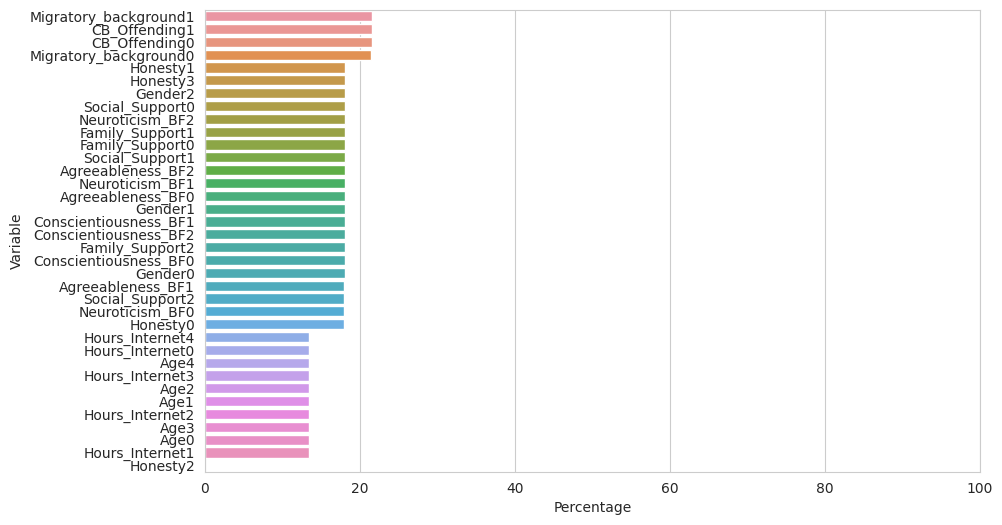

In [48]:
plot_var_count(df=df_6_join, var='P(Riksy|Evidence)', threshold=0.25)

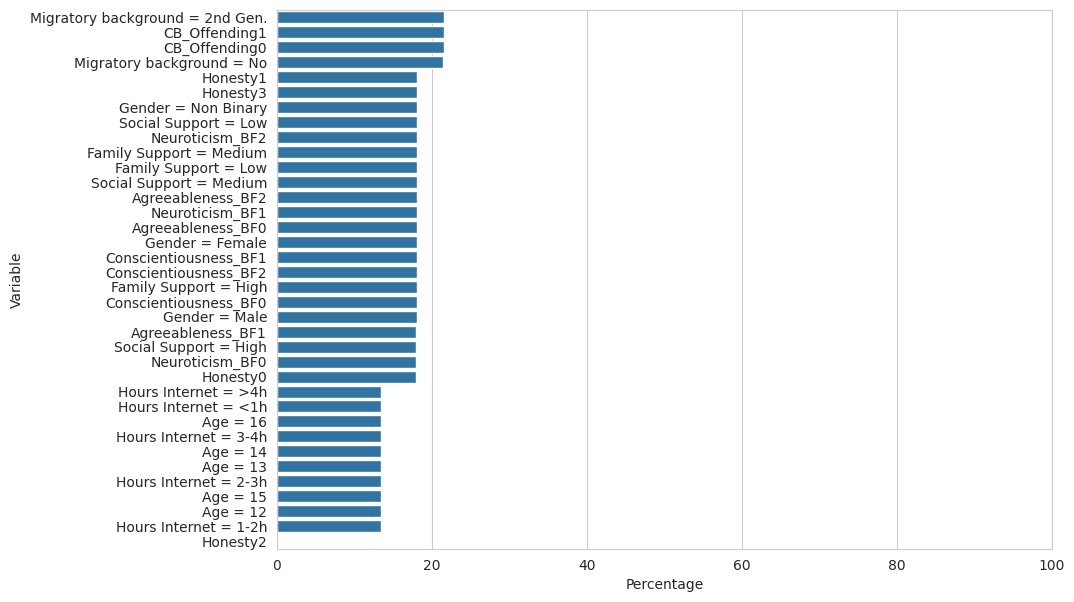

In [49]:
plot_var_count_elegant(df=df_6_join, var='P(Riksy|Evidence)', threshold=0.25)

### 7 variables analysis

In [50]:
df_7_join_ = compute_rank_evidencesv2(7, dict_val_FN,
                                      network_file_FN, var_interest_FN)
df_7_join = df_7_join_.sort_values(by=['P(Riksy|Evidence)'])
df_7_join

,P(Evidence|Risky),P(Evidence),P(Riksy|Evidence)
"(Age3, Gender0, Honesty2, Hours_Internet2, Migratory_background0, Neuroticism_BF0, Social_Support2)",0.002176,0.001505,0.144645
"(Age3, Conscientiousness_BF1, Gender0, Honesty2, Hours_Internet2, Neuroticism_BF0, Social_Support2)",0.001527,0.000997,0.153186
"(Age0, Agreeableness_BF2, Conscientiousness_BF2, Honesty2, Hours_Internet1, Neuroticism_BF0, Social_Support2)",0.000299,0.000189,0.158109
"(Age3, Family_Support2, Gender0, Honesty2, Hours_Internet2, Neuroticism_BF0, Social_Support2)",0.002953,0.001863,0.158497
"(Age3, Agreeableness_BF0, Gender0, Honesty2, Hours_Internet2, Neuroticism_BF0, Social_Support2)",0.001597,0.001006,0.158689
...,...,...,...
"(Age4, Agreeableness_BF0, CB_Offending1, Conscientiousness_BF0, Honesty1, Hours_Internet3, Neuroticism_BF1)",0.002145,0.000410,0.523679
"(Age3, Agreeableness_BF0, Conscientiousness_BF1, Gender0, Honesty1, Migratory_background0, Neuroticism_BF1)",0.010152,0.001916,0.529994
"(Age1, Agreeableness_BF0, Conscientiousness_BF2, Honesty1, Hours_Internet1, Migratory_background0, Neuroticism_BF0)",0.002713,0.000512,0.530196
"(Age1, Agreeableness_BF0, Conscientiousness_BF2, Honesty1, Hours_Internet1, Neuroticism_BF0, Social_Support2)",0.002631,0.000494,0.532742


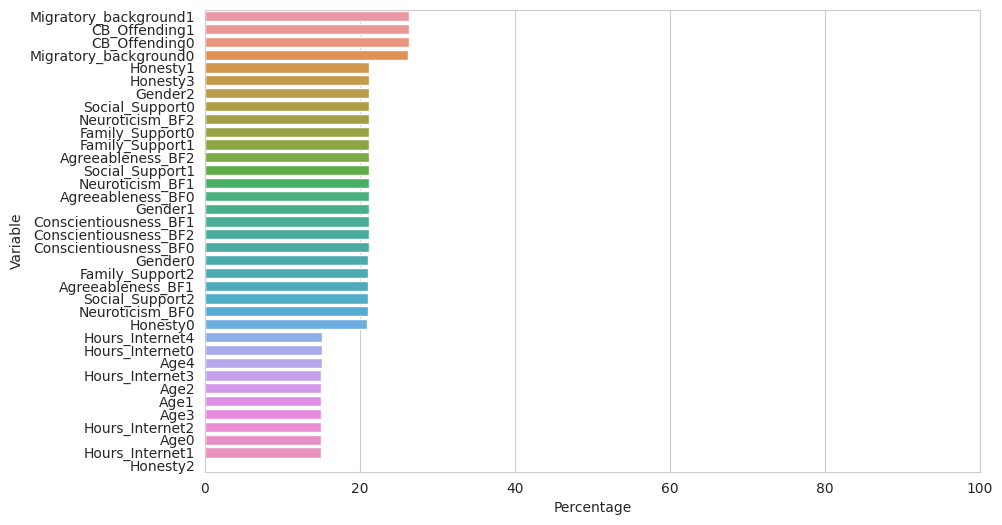

In [51]:
plot_var_count(df=df_7_join, var='P(Riksy|Evidence)', threshold=0.25)

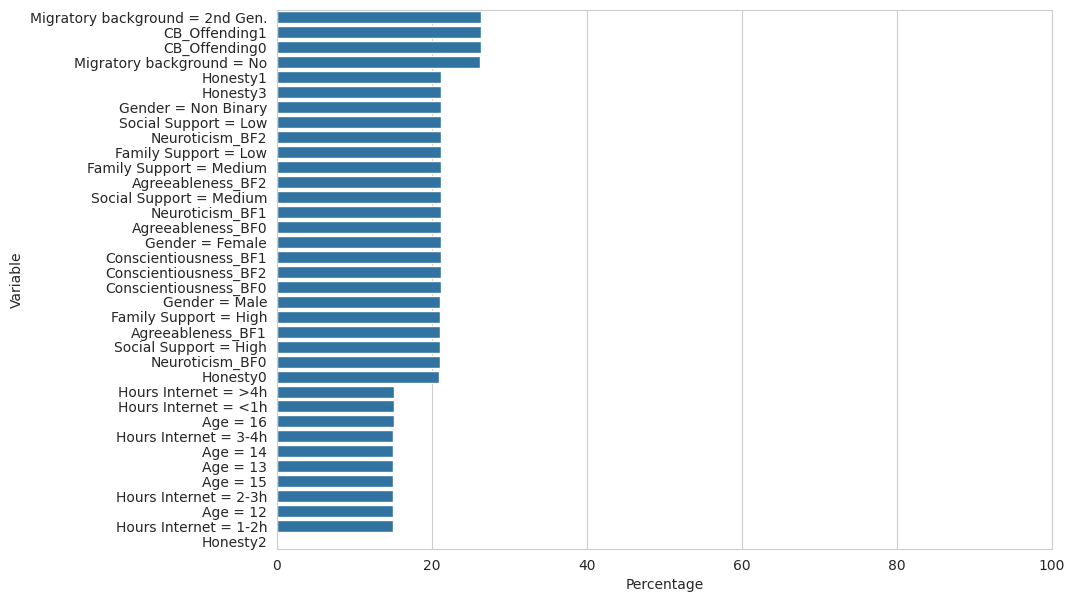

In [52]:
plot_var_count_elegant(df=df_7_join, var='P(Riksy|Evidence)', threshold=0.25)

### 8 variables analysis

In [53]:
df_8_join_ = compute_rank_evidencesv2(8, dict_val_FN,
                                      network_file_FN, var_interest_FN)
df_8_join = df_8_join_.sort_values(by=['P(Riksy|Evidence)'])
df_8_join

,P(Evidence|Risky),P(Evidence),P(Riksy|Evidence)
"(Age3, Conscientiousness_BF1, Gender0, Honesty2, Hours_Internet2, Migratory_background0, Neuroticism_BF0, Social_Support2)",0.000874,0.000662,0.132030
"(Age3, Agreeableness_BF0, Gender0, Honesty2, Hours_Internet2, Migratory_background0, Neuroticism_BF0, Social_Support2)",0.000889,0.000670,0.132713
"(Age3, Family_Support2, Gender0, Honesty2, Hours_Internet2, Migratory_background0, Neuroticism_BF0, Social_Support2)",0.001659,0.001240,0.133842
"(Age3, CB_Offending0, Gender0, Honesty2, Hours_Internet2, Migratory_background0, Neuroticism_BF0, Social_Support2)",0.001810,0.001319,0.137260
"(Age3, Agreeableness_BF1, Conscientiousness_BF1, Gender0, Honesty2, Hours_Internet2, Neuroticism_BF0, Social_Support2)",0.000581,0.000421,0.137802
...,...,...,...
"(Age3, Agreeableness_BF0, Conscientiousness_BF1, Gender0, Honesty1, Hours_Internet2, Neuroticism_BF1, Social_Support2)",0.003326,0.000568,0.585435
"(Age1, Agreeableness_BF0, Conscientiousness_BF2, Honesty1, Hours_Internet1, Migratory_background0, Neuroticism_BF0, Social_Support2)",0.001971,0.000333,0.591613
"(Age1, Agreeableness_BF0, Conscientiousness_BF2, Gender0, Hours_Internet1, Migratory_background0, Neuroticism_BF0, Social_Support2)",0.003249,0.000532,0.611162
"(Age1, Agreeableness_BF0, Conscientiousness_BF2, Gender0, Honesty1, Hours_Internet1, Migratory_background0, Neuroticism_BF0)",0.001780,0.000287,0.619863


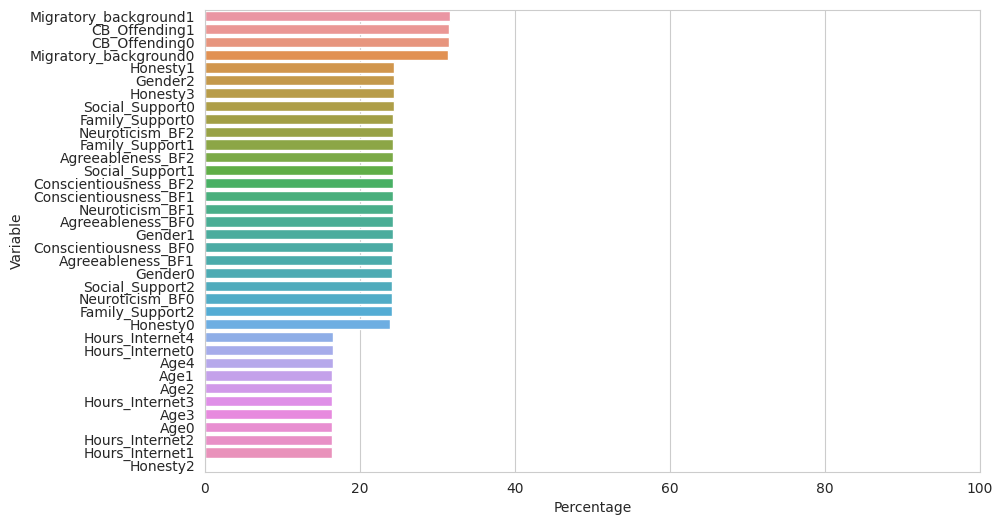

In [54]:
plot_var_count(df=df_8_join, var='P(Riksy|Evidence)', threshold=0.25)

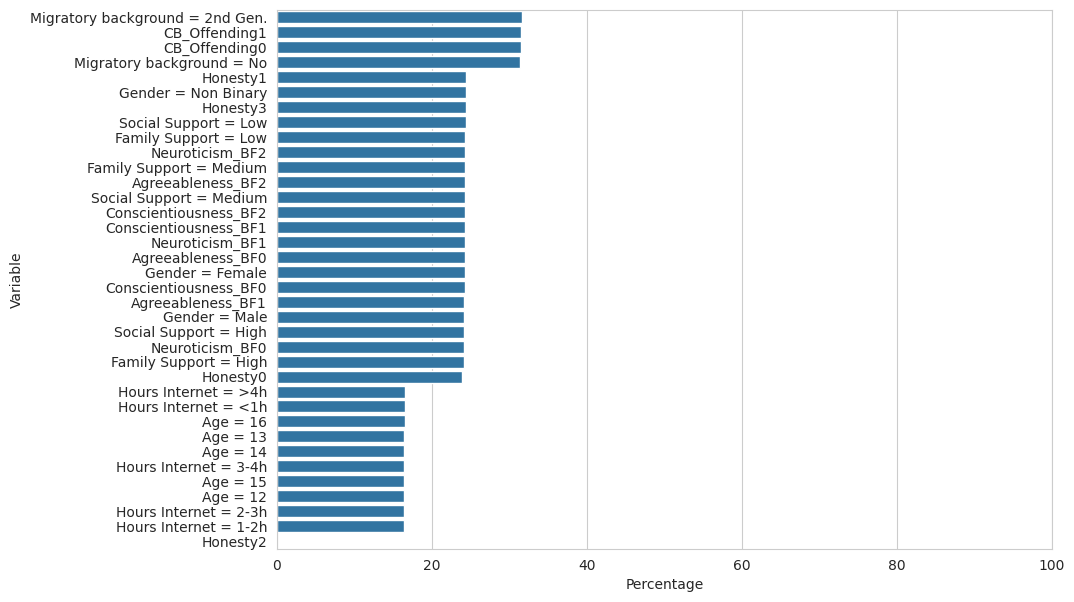

In [55]:
plot_var_count_elegant(df=df_8_join, var='P(Riksy|Evidence)', threshold=0.25)

### 9 variables analysis

In [56]:
df_9_join_ = compute_rank_evidencesv2(9, dict_val_FN,
                                      network_file_FN, var_interest_FN)
df_9_join = df_9_join_.sort_values(by=['P(Riksy|Evidence)'])
df_9_join

,P(Evidence|Risky),P(Evidence),P(Riksy|Evidence)
"(Age3, Agreeableness_BF1, Conscientiousness_BF1, Gender0, Honesty2, Hours_Internet2, Migratory_background0, Neuroticism_BF0, Social_Support2)",0.000287,0.000283,0.101706
"(Age1, Agreeableness_BF1, Conscientiousness_BF2, Gender0, Honesty2, Hours_Internet1, Migratory_background0, Neuroticism_BF1, Social_Support1)",0.000126,0.000116,0.108322
"(Age3, Conscientiousness_BF1, Family_Support2, Gender0, Honesty2, Hours_Internet2, Migratory_background0, Neuroticism_BF0, Social_Support2)",0.000644,0.000547,0.117845
"(Age1, Agreeableness_BF2, Conscientiousness_BF2, Gender0, Honesty2, Hours_Internet1, Migratory_background0, Neuroticism_BF0, Social_Support2)",0.000067,0.000056,0.118986
"(Age3, Agreeableness_BF0, Conscientiousness_BF2, Gender0, Honesty2, Hours_Internet2, Migratory_background0, Neuroticism_BF0, Social_Support2)",0.000204,0.000171,0.119223
...,...,...,...
"(Age4, Agreeableness_BF0, CB_Offending1, Conscientiousness_BF0, Honesty1, Hours_Internet3, Migratory_background0, Neuroticism_BF1, Social_Support2)",0.001222,0.000187,0.651997
"(Age4, Agreeableness_BF0, CB_Offending1, Conscientiousness_BF0, Gender0, Honesty1, Hours_Internet3, Migratory_background0, Neuroticism_BF1)",0.001067,0.000163,0.655209
"(Age3, Agreeableness_BF0, CB_Offending0, Conscientiousness_BF1, Gender0, Honesty1, Hours_Internet2, Migratory_background0, Neuroticism_BF1)",0.004024,0.000612,0.657276
"(Age3, Agreeableness_BF0, Conscientiousness_BF1, Gender0, Honesty1, Hours_Internet2, Migratory_background0, Neuroticism_BF1, Social_Support2)",0.002689,0.000392,0.685361


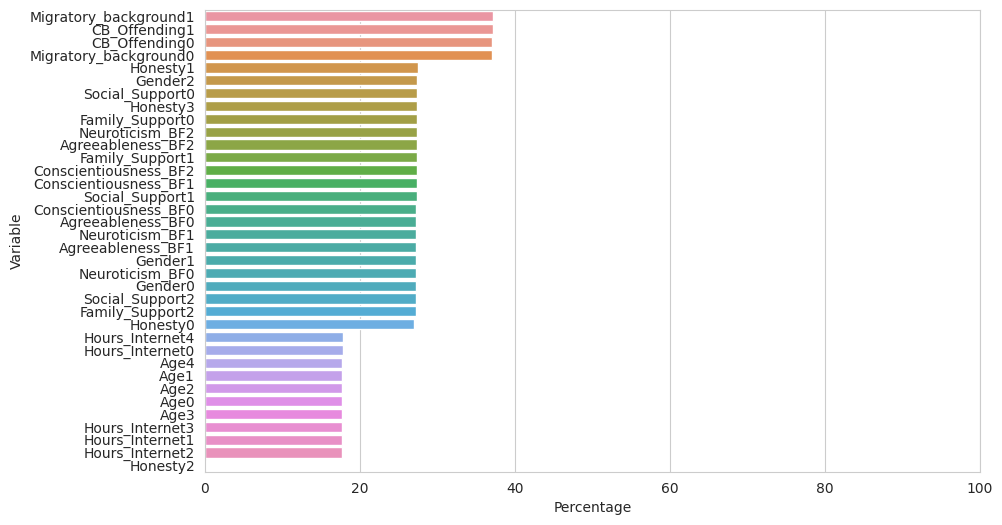

In [57]:
plot_var_count(df=df_9_join, var='P(Riksy|Evidence)', threshold=0.25)

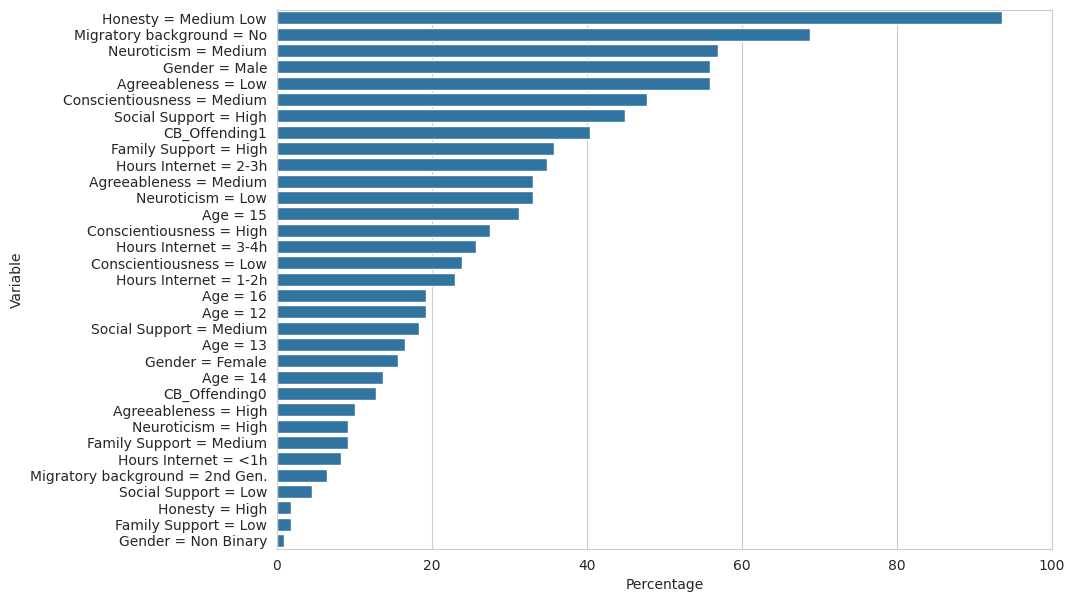

In [75]:
plot_var_count_elegant(df=df_9_join, var='P(Riksy|Evidence)', threshold=0.57)

# Plot

## Max P(Riksy|Evidence) // Nº Var

In [59]:
q_max = []
for i in range(1, 7):
  q_max.append(float(globals()[f'df_q_{i}_join'].tail(1)['P(Riksy|Evidence)']))

dict_q = {'Max': q_max,
          'Data Type': ['Game Questions']*6,
          'vars': list(range(1, 7))}

q_max_evidence = []
for i in range(1, 7):
  q_max_evidence.append(float(globals()[f'df_q_{i}_join'].tail(1)['P(Evidence|Risky)']))

dict_q_evidence = {'Max': q_max_evidence,
                  'Data Type': ['Game P(Evidence|Risky)']*6,
                  'vars': list(range(1, 7))}

In [60]:
dem_max = []
for i in range(1, 10):
  dem_max.append(float(globals()[f'df_{i}_join'].tail(1)['P(Riksy|Evidence)']))

dict_dem = {'Max': dem_max,
            'Data Type': ['Profiling']*9,
            'vars': list(range(1, 10))}

dem_max_evidence = []
for i in range(1, 10):
  dem_max_evidence.append(float(globals()[f'df_{i}_join'].tail(1)['P(Evidence|Risky)']))

dict_dem_evidence = {'Max': dem_max_evidence,
                    'Data Type': ['Profiling P(Evidence|Risky)']*9,
                    'vars': list(range(1, 10))}

In [61]:
dict_dem

{'Max': [0.41705911778052357,
  0.4199912373272088,
  0.4243748250016443,
  0.43137846884285064,
  0.45093885927541594,
  0.4910503426738243,
  0.5522185778934854,
  0.6248170875586043,
  0.7227676086691424],
 'Data Type': ['Profiling',
  'Profiling',
  'Profiling',
  'Profiling',
  'Profiling',
  'Profiling',
  'Profiling',
  'Profiling',
  'Profiling'],
 'vars': [1, 2, 3, 4, 5, 6, 7, 8, 9]}

In [62]:
df_max = pd.concat([pd.DataFrame(dict_q),
                    # pd.DataFrame(dict_q_evidence),
                    pd.DataFrame(dict_dem),
                    # pd.DataFrame(dict_dem_evidence)
                    ], ignore_index=True)
df_max

,Max,Data Type,vars
0,0.559989,Game Questions,1
1,0.645543,Game Questions,2
2,0.692489,Game Questions,3
3,0.753092,Game Questions,4
4,0.781949,Game Questions,5
5,0.800374,Game Questions,6
6,0.417059,Profiling,1
7,0.419991,Profiling,2
8,0.424375,Profiling,3
9,0.431378,Profiling,4


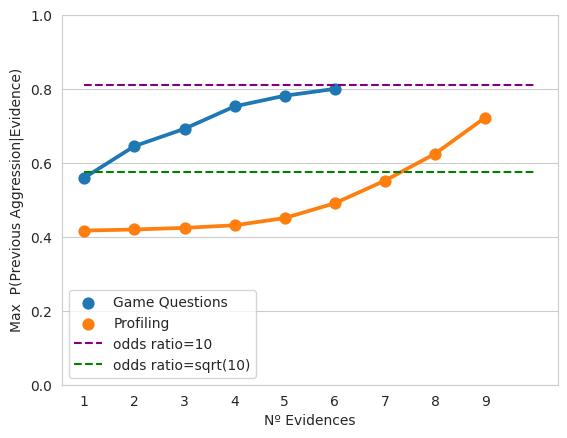

In [73]:
sns.pointplot(df_max, x='vars', y='Max', hue='Data Type')
plt.ylabel('Max  P(Previous Aggression|Evidence)')
plt.hlines(0.81, 0, 9, 'purple', linestyles='dashed', label='odds ratio=10')
plt.hlines(0.5754, 0, 9, 'green', linestyles='dashed', label='odds ratio=sqrt(10)')
plt.xlabel('Nº Evidences')
plt.ylim((0,1))
plt.legend(loc='lower left')
plt.savefig("Analysis2FN.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [68]:
df_max_2 = pd.concat([pd.DataFrame(dict_q),
                    pd.DataFrame(dict_dem)], ignore_index=True)
df_max_2

,Max,Data Type,vars
0,0.559989,Game Questions,1
1,0.645543,Game Questions,2
2,0.692489,Game Questions,3
3,0.753092,Game Questions,4
4,0.781949,Game Questions,5
5,0.800374,Game Questions,6
6,0.417059,Profiling,1
7,0.419991,Profiling,2
8,0.424375,Profiling,3
9,0.431378,Profiling,4


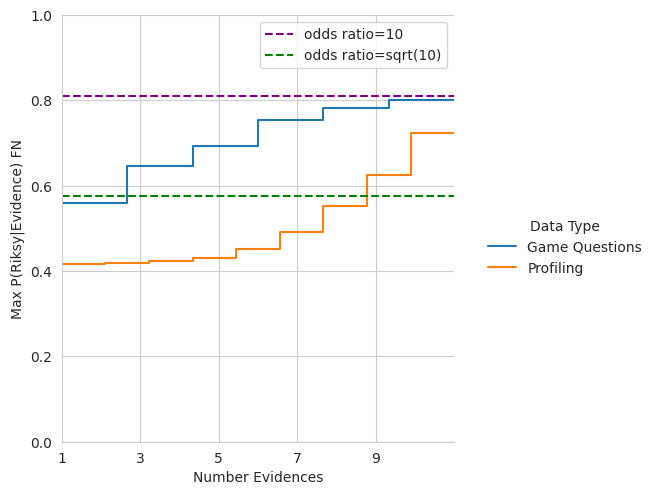

In [69]:
sns.displot(df_max_2, y='Max', hue='Data Type', kind='ecdf')
plt.hlines(0.81, 0, 1, 'purple', linestyles='dashed', label='odds ratio=10')
plt.hlines(0.5754, 0, 1, 'green', linestyles='dashed', label='odds ratio=sqrt(10)')
plt.ylabel('Max P(Riksy|Evidence) FN')
plt.xlabel('Number Evidences')
plt.ylim((0,1))
ticks, labels = plt.xticks()
labels = [1, 3, 5, 7, 9, '']
plt.xticks(ticks, labels)
plt.legend()

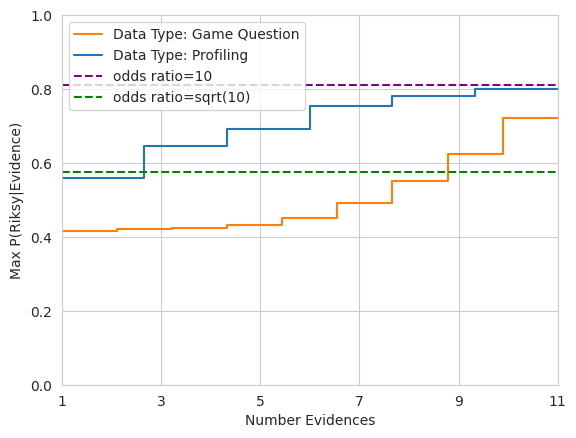

In [71]:
sns.ecdfplot(df_max_2, y='Max', hue='Data Type')
plt.hlines(0.81, 0, 1, 'purple', linestyles='dashed', label='odds ratio=10')
plt.hlines(0.5754, 0, 1, 'green', linestyles='dashed', label='odds ratio=sqrt(10)')
plt.ylabel('Max P(Riksy|Evidence)')
plt.xlabel('Number Evidences')
plt.ylim((0,1))
ticks, labels = plt.xticks()
labels = [1, 3, 5, 7, 9, 11]
plt.xticks(ticks, labels)
plt.legend(['Data Type: Game Question', 'Data Type: Profiling', 'odds ratio=10', 'odds ratio=sqrt(10)'])
plt.savefig("Analysis2_stair.pdf", format="pdf", bbox_inches="tight")

## Max P(Evidence|Riksy) // Nº Var

In [72]:
q_max_2 = []
for i in range(1, 7):
  q_max_2.append(float(globals()[f'df_q_{i}_join']['P(Evidence|Risky)'].max()))

dict_q_2 = {'Max': q_max_2,
          'Type': ['Game Question']*6,
          'vars': list(range(1, 7))}


In [ ]:
dem_max_2 = []
for i in range(1, 10):
  dem_max_2.append(float(globals()[f'df_{i}_join']['P(Evidence|Risky)'].max()))

dict_dem_2 = {'Max': dem_max_2,
            'Type': ['Demographic']*9,
            'vars': list(range(1, 10))}

In [ ]:
df_max_2 = pd.concat([pd.DataFrame(dict_q_2),
                    pd.DataFrame(dict_dem_2)], ignore_index=True)
df_max_2

In [ ]:
sns.pointplot(df_max_2, x='vars', y='Max', hue='Type')
plt.ylabel('Max P(Evidence|Risky) FN')
plt.ylim((0,1))

## % risky // Nº Var

In [ ]:
threshold_risky = 0.25

In [ ]:
import math

In [ ]:
q_len = []
for i in range(1, 7):
  _df = globals()[f'df_q_{i}_join']
  len_total = len(_df)
  len_risky = len(_df[_df['P(Riksy|Evidence)']>threshold_risky])
  q_len.append(len_risky/len_total)

dict_q_len = {'Percent': q_len,
          'Type': ['Game Question']*6}

In [ ]:
dem_len = []
for i in range(1, 10):
  _df = globals()[f'df_{i}_join']
  len_total = len(_df)
  len_risky = len(_df[_df['P(Riksy|Evidence)']>threshold_risky])
  dem_len.append(len_risky/len_total)

dict_dem_len = {'Percent': dem_len,
          'Type': ['Demographic']*9}

In [ ]:
'''comb_max = []
for i in range(1, 11):
  comb_max.append(float(globals()[f'df_comb_{i}'].max()))

dict_comb = {'Max': comb_max,
            'Type': ['Combine']*10}'''

In [ ]:
df_len = pd.concat([pd.DataFrame(dict_q_len), pd.DataFrame(dict_dem_len)], ignore_index=True)
df_len

In [ ]:
sns.displot(df_len, y='Percent', hue='Type', kind='ecdf')
plt.ylabel('% of risky profiles FN')
plt.ylim((0,1))